In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [133]:
df = pd.read_csv('../feature_selection.csv')
df.head()

,Unnamed: 0,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_ec,koi_time0bk,koi_time0bk_err1,koi_duration,koi_duration_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_insol_err2,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_slogg,koi_slogg_err1,koi_srad,koi_disposition
0,3625,0,0,0,215.520400,0.008060,8.0290,0.2100,-42.2,1.61,0.10,-0.11,1.0,4133.0,74.0,4.705,0.023,0.561,1
1,362,0,1,0,134.365782,0.000745,9.0419,0.0550,-63.7,16.91,6.01,-255.78,1.0,6715.0,161.0,4.347,0.056,1.241,0
2,8826,1,0,0,141.074600,0.014000,2.3060,0.5980,-42.3,1.22,0.51,-6.05,1.0,6046.0,172.0,4.486,0.044,0.972,0
3,2757,0,0,0,173.903550,0.001380,5.1803,0.0504,-14.5,3.56,0.57,-11.96,1.0,5951.0,107.0,4.319,0.120,1.155,1
4,6557,1,0,0,263.471000,0.031900,18.1800,1.4000,-16.5,2.85,1.25,-1.62,1.0,5636.0,173.0,3.809,0.459,2.357,0


In [134]:
n = 30
random_state = 42

# Load Digits dataset
X = df.drop("koi_disposition", axis=1)
y = df["koi_disposition"]

In [135]:
# Split into train/test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, stratify=y,
                     random_state=random_state)

In [136]:
n_classes = len(np.unique(y))
n_features = len(df.columns)

In [137]:
res = {}
for n_neighbors in range(1,n) :
# Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(),
                        PCA(random_state=random_state))

    # Reduce dimension to 2 with LinearDiscriminantAnalysis
    lda = make_pipeline(StandardScaler(),
                        LinearDiscriminantAnalysis())

    # Reduce dimension to 2 with NeighborhoodComponentAnalysis
    nca = make_pipeline(StandardScaler(),
                        NeighborhoodComponentsAnalysis(random_state=random_state))

    # Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    # Make a list of the methods to be compared
    dim_reduction_methods = [('PCA', pca), ('LDA', lda), ('NCA', nca)]

    for i, (name, model) in enumerate(dim_reduction_methods):
        # Fit the method's model
        model.fit(X_train, y_train)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(model.transform(X_train), y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(model.transform(X_test), y_test)
        print(acc_knn)
        if name not in res.keys():
            res[name] = [acc_knn]
        else: res[name].append(acc_knn)
    # Embed the data set in 2 dimensions using the fitted model

0.9383333333333334
0.9066666666666666
0.9366666666666666
0.9316666666666666
0.8916666666666667
0.94
0.94
0.9266666666666666
0.94
0.9383333333333334
0.92
0.9416666666666667
0.945
0.935
0.94
0.9416666666666667
0.9283333333333333
0.94
0.9466666666666667
0.93
0.9466666666666667
0.9433333333333334
0.93
0.9433333333333334
0.9433333333333334
0.9333333333333333
0.945
0.945
0.93
0.9483333333333334
0.9483333333333334
0.935
0.9416666666666667
0.9433333333333334
0.9383333333333334
0.9416666666666667
0.945
0.935
0.9383333333333334
0.945
0.9383333333333334
0.94
0.9483333333333334
0.9416666666666667
0.9366666666666666
0.95
0.9383333333333334
0.9383333333333334
0.9466666666666667
0.9433333333333334
0.935
0.945
0.94
0.935
0.9433333333333334
0.9433333333333334
0.9316666666666666
0.9433333333333334
0.945
0.9316666666666666
0.9433333333333334
0.94
0.9283333333333333
0.9433333333333334
0.9416666666666667
0.9333333333333333
0.9433333333333334
0.9416666666666667
0.93
0.9416666666666667
0.9416666666666667
0.9

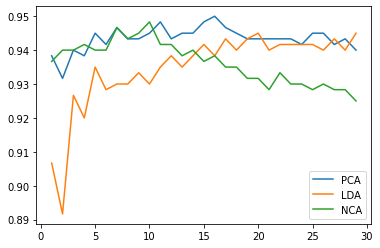

In [140]:
xaxis = range(1,n)
plt.plot(xaxis, res['PCA'], label = 'PCA')
plt.plot(xaxis, res['LDA'], label = 'LDA')
plt.plot(xaxis, res['NCA'], label = 'NCA')
plt.legend()
plt.savefig("plot.pdf")